## FERC <> EIA Granular Connections

Notes on the type of problem we are trying to solve:
- A classification problem
    - A Multi-Class Classification problem*
- A deterministic problem
- A record linkage problem

Right now, we are using the recordlinkage package. We're using logistic regression classifier because it fits all of the above.

What we still need:
- determine how to restrict the results to one eia record per ferc record! - DONE (with more fine tuning to come)
- Remove false granularities in the MUL - DONE
    - Partent/Child granularities - DONE
    - Peer/peer granularities - DONE
- fine tune the comparison metric for heat rate and total fuel cost. (Issue #22)
- add in additional FERC tabels (Issue #21)
- more test data!
- so, so much more.

To consider:
- Maybe we want to run the records with fuel cost data through a different matching model...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy
import scipy
import statistics
import yaml

import recordlinkage as rl
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
sys.path.append("../")
from pudl.output.ferc1 import *
from connect_ferc1_to_eia import *
from make_plant_parts_eia import *
import connect_ferc1_to_eia #ferc_eia_connections
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pd.options.display.max_columns = None

### Pull in data (EIA, FERC and training)

In [5]:
# compliers for training data
table_compiler = CompileTables(pudl_engine, freq='AS', rolling=True)
parts_compilers = CompilePlantParts(table_compiler,clobber=True)
compiler_train = connect_ferc1_to_eia.TrainXlxsCompiler('pudl_machine_learning.xlsx')

In [6]:
file_path_mul = pathlib.Path().cwd().parent /  'master_unit_list.pkl.gz'
plant_parts_df = get_master_unit_list_eia(file_path_mul)
parts_compilers.plant_parts_df = plant_parts_df
plant_parts_df = plant_parts_df[plant_parts_df['true_gran'] == True]

Reading the master unit list from /Users/christinagosnell/code/rmi-ferc1-eia/master_unit_list.pkl.gz


In [7]:
train_df_ids = connect_ferc1_to_eia.prep_train_connections(parts_compilers,compiler_train)

grabbing xlxs file.


In [8]:
# pudl output object for ferc data
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS')

In [9]:
steam_cleaned = connect_ferc1_to_eia.prep_ferc_data(pudl_out)

Converting the dtypes of: ferc1 plant records


In [10]:
file_path_steam_ferc1 = pathlib.Path().cwd().parent /  'steam_ferc1.pkl.gz'
steam_cleaned.to_pickle(file_path_steam_ferc1, compression='gzip')

### Generate known test datasets

In [11]:
# generate the list of the records in the EIA and FERC records that exist
# in the training data
eia_known = (plant_parts_df.merge(train_df_ids.reset_index().drop(columns=['record_id_ferc'])[['record_id_eia']],
                          left_index=True,
                          right_on=['record_id_eia']
                                 ).
            drop_duplicates(subset=['record_id_eia']).
            set_index('record_id_eia').
            astype({'total_fuel_cost':float,
                    'total_mmbtu':float}))

ferc_known = (steam_cleaned.merge(train_df_ids.reset_index().drop(columns=['record_id_eia'])[['record_id_ferc']],
                          left_index=True,
                          right_on=['record_id_ferc']).
             drop_duplicates(subset=['record_id_ferc']).
             set_index('record_id_ferc').
             astype({'total_fuel_cost':float,
                     'total_mmbtu':float}))

# Omigosh the actual Matching

In [12]:
dfA_known = ferc_known
dfB_known = eia_known
dfA = steam_cleaned#[steam_cleaned['report_year'] == 2018]
dfB = plant_parts_df#[plant_parts_df['report_year'] == 2018]

In [13]:
print(dfA_known.shape)
print(dfB_known.shape)
print(dfA.shape)
print(dfB.shape)

(309, 21)
(246, 34)
(14443, 21)
(404202, 34)


#### Making Comparison Feature Vectors

In [14]:
features_all = connect_ferc1_to_eia.make_features(dfA=ferc_known, dfB=eia_known, block_col='plant_id_report_year')
features_known = connect_ferc1_to_eia.make_features(dfA=steam_cleaned, dfB=plant_parts_df, block_col='plant_id_report_year')

In [15]:
features_all.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,129254.0,0.725201,0.110618,0.0,6.643275e-01,7.384259e-01,8.109244e-01,0.952381
net_generation_mwh,129254.0,0.087611,0.253303,0.0,0.000000e+00,1.315864e-278,8.577401e-27,1.000000
capacity_mw,129254.0,0.106220,0.269221,0.0,4.282823e-20,4.006553e-09,6.301889e-03,1.000000
total_fuel_cost,129254.0,0.085756,0.190891,0.0,0.000000e+00,0.000000e+00,6.698907e-28,1.000000
total_mmbtu,129254.0,0.092731,0.205574,0.0,0.000000e+00,0.000000e+00,2.171198e-185,1.000000
capacity_factor,129254.0,0.852335,0.240389,0.0,8.090453e-01,9.577568e-01,9.912470e-01,1.000000
fuel_cost_per_mmbtu,129254.0,0.357402,0.440226,0.0,0.000000e+00,0.000000e+00,9.033606e-01,0.999991
heat_rate_mmbtu_mwh,129254.0,0.272570,0.405900,0.0,0.000000e+00,0.000000e+00,7.588138e-01,1.000000
fuel_type_code_pudl,129254.0,0.608817,0.488017,0.0,0.000000e+00,1.000000e+00,1.000000e+00,1.000000
installation_year,129254.0,0.386317,0.486907,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000


In [16]:
features_known.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,355.0,0.736941,0.090275,3.518519e-01,6.740741e-01,7.440476e-01,8.008658e-01,0.925926
net_generation_mwh,355.0,0.183209,0.367956,0.000000e+00,0.000000e+00,4.353066e-83,2.353184e-03,1.000000
capacity_mw,355.0,0.358720,0.447921,2.324785e-96,1.123186e-15,2.378059e-03,9.726549e-01,1.000000
total_fuel_cost,355.0,0.097610,0.196137,0.000000e+00,0.000000e+00,8.770223e-197,1.345624e-06,0.500000
total_mmbtu,355.0,0.124117,0.241907,0.000000e+00,0.000000e+00,0.000000e+00,1.888020e-12,1.000000
capacity_factor,355.0,0.905937,0.152481,0.000000e+00,8.913250e-01,9.621275e-01,9.951800e-01,1.000000
fuel_cost_per_mmbtu,355.0,0.446591,0.454394,0.000000e+00,0.000000e+00,2.642372e-01,9.338689e-01,0.999960
heat_rate_mmbtu_mwh,355.0,0.363906,0.438448,0.000000e+00,0.000000e+00,0.000000e+00,8.544515e-01,1.000000
fuel_type_code_pudl,355.0,0.684507,0.465368,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000
installation_year,355.0,0.583099,0.493742,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000


### Classificaiton Models

In [17]:
%%time
# this cell takes a fair amount of time (> 2 minutes on my computer)
# it is testing an array of model hyper parameters and 
# cross-vaildating with the training data. It returns a df with losts
# of result scores to be used to find the best resutls
results_options = connect_ferc1_to_eia.test_model_parameters(
    features_known, train_df_ids.index, 10)

CPU times: user 1min 57s, sys: 1.09 s, total: 1min 58s
Wall time: 2min 7s


In [18]:
results_options = results_options.sort_values(['f_score','precision','accuracy'],ascending=False)
best = results_options.head(1)

In [19]:
best

,solver,precision,f_score,accuracy,c,cw,penalty,l1,multi_class,predictions,coef,interc
0,saga,0.841666,0.866537,0.74124,1,None,elasticnet,0.3,auto,252,"[0.0, 1.847234923487772, 1.9041237383451528, 0...",-4.106951


In [20]:
prediction_df = fit_predict_lrc(best,features_known, features_all, train_df_ids)

In [21]:
coefs = best['coef'].values[0]
weighted_feats_all = weight_features(features_all,coefs)
feats_all = calc_match_stats(weighted_feats_all)

results_weighted = weight_features(prediction_df,coefs)
results = calc_match_stats(results_weighted)
results = results.merge(feats_all[['iqr']],
                        left_index=True,
                        right_index=True,
                        how='left',
                        suffixes=("","_all"))

In [22]:
# this looks a little weird to me. having the net gen be the most 
# important makes some sense, but is is suspiciously high, imo.
weights = pd.DataFrame(
    data={'feature':features_all.columns,
          'weight': coefs
         })
weights

,feature,weight
0,plant_name,0.000000
1,net_generation_mwh,1.847235
2,capacity_mw,1.904124
3,total_fuel_cost,0.000000
4,total_mmbtu,0.000000
5,capacity_factor,0.088838
6,fuel_cost_per_mmbtu,-1.159833
7,heat_rate_mmbtu_mwh,0.988790
8,fuel_type_code_pudl,1.232647
9,installation_year,0.537741


In [24]:
winners = calc_wins(results, dfA, .1)
murk_df = calc_murk(results,.1)

matches vs total ferc:  0.59
wins vs total ferc:     0.44
wins vs matches:        0.74
murk vs matches:        0.091
ties vs matches:        0.14


In [25]:
def plot_all_hist(all_df,results_df,murk_df, winners_df, range):
    if all_df is not None:
        plt.hist(all_df['score'], 
                 range=range,
                 bins=100,
                 color="pink",
                 label='all options'
                )
    if results_df is not None:
        plt.hist(results_df['score'], 
                 range=range,
                 bins=100,
                 color="purple",
                 label='all model matches'
                )
    if winners_df is not None:
        plt.hist(winners_df['score'], 
                 range=range,
                 bins=100,
                 color="turquoise",
                 label='winning options'
                )
    if murk_df is not None:
        plt.hist(murk_df['score'], 
                 range=range,
                 bins=100,
                 color="grey",
                 label='murky wins'
                )

    plt.title(f'weighted score of comparision features')
    plt.xlabel('weighted sum')
    plt.ylabel(None)
    plt.legend()
    plt.show()

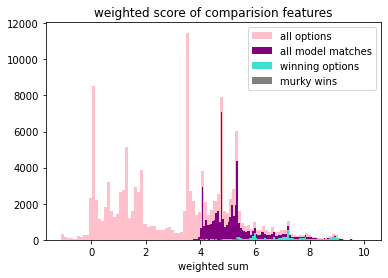

In [26]:
plot_all_hist(feats_all,results,murk_df, winners, range=None)

In [27]:
file_path_ferc1_eia = pathlib.Path().cwd().parent /  'ferc1_to_eia.pkl.gz'
winners.to_pickle(file_path_ferc1_eia, compression='gzip')

In [28]:
wins = (winners.reset_index().merge(plant_parts_df.
              reset_index()[['record_id_eia','plant_part','capacity_mw']],
              on=['record_id_eia'],
              how='left',
              suffixes=('_feature','')
             ).
        groupby(['plant_part']).
        agg({'capacity_mw':sum,
             'score': 'count'}).
        assign(count_w=lambda x: x.capacity_mw * x.score,
               percent_w=lambda x: x.count_w/x.sum()['count_w'],
               percent=lambda x: x.score/x.sum()['score'],
              )
       )

wins

,capacity_mw,score,count_w,percent_w,percent
plant_part,,,,,
plant,2.373957e+06,4310,1.023176e+10,0.973154,0.684236
plant_gen,4.590197e+04,421,1.932473e+07,0.001838,0.066836
plant_prime_fuel,2.090110e+04,57,1.191363e+06,0.000113,0.009049
plant_prime_mover,1.653457e+05,969,1.602199e+08,0.015239,0.153834
plant_technology,1.314280e+04,43,5.651404e+05,0.000054,0.006826
plant_unit,2.023309e+05,499,1.009631e+08,0.009603,0.079219


#### Investigation of Murky Wins

In [28]:
# choose a murk... 
murk_df.sample()

,,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,plant_name,total_fuel_cost,total_mmbtu,utility_id_pudl,rank,diffs,count,iqr,iqr_all
record_id_ferc,record_id_eia,,,,,,,,,,,,,,,,,
f1_steam_2010_12_99_1_4,6073_ct_2010_plant_prime_mover_owned_12686,6.059749,0.0,2.827894e-10,-0.0,1.342379,0.0,0.468789,0.0,0.0,0.0,0.0,4.248582,1.0,2.827889e-10,9,1.031029,3.990824


In [29]:
# grab the f1_id and peer into the plant
f1_id = 'f1_steam_2013_12_57_3_4'
results.loc[f1_id]

,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,plant_name,total_fuel_cost,total_mmbtu,utility_id_pudl,rank,diffs,count,iqr,iqr_all
record_id_eia,,,,,,,,,,,,,,,,,
6052_1_2013_plant_unit_total_7140,4.992047,0.0,2.033977e-02,-1.07873,1.342379,0.459477,0.000000,2.719339e-177,0.0,0.0,0.0,4.248582,3.0,NaN,3,0.24448,1.204093
6052_2_2013_plant_unit_owned_7140,5.452675,0.0,1.335489e-15,-1.07873,1.342379,0.471656,0.468789,1.551578e-177,0.0,0.0,0.0,4.248582,2.0,0.460628,3,0.24448,1.204093
6052_2_2013_plant_unit_total_7140,5.481007,0.0,2.033977e-02,-1.07873,1.342379,0.471656,0.468789,7.992292e-03,0.0,0.0,0.0,4.248582,1.0,0.028332,3,0.24448,1.204093


In [30]:
dfA.loc[[f1_id]]

,report_year,utility_id_ferc1,plant_name_ferc1,utility_id_pudl,plant_id_pudl,plant_id_ferc1,capacity_factor,capacity_mw,net_generation_mwh,opex_fuel,fuel_cost_per_mwh,total_fuel_cost,total_mmbtu,construction_year,installation_year,fuel_type_code_pudl,plant_type,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,plant_id_report_year
record_id_ferc,,,,,,,,,,,,,,,,,,,,
f1_steam_2013_12_57_3_4,2013,57,wansley,123,659,215,0.144386,1019.0,1288850.921,64680869.0,50.184911,63600579.5,1.433585e+07,1976,1978,coal,steam,4.43647,11.122972,659_2013


In [31]:
dfB[((dfB['plant_id_eia'] == 7991)
     #& (dfB['utility_id_eia'] == 343)
    )
    #& ((dfB['plant_part'] == 'plant') | (dfB['plant_part'] == 'plant_unit'))
    #& ((dfB['generator_id'] == '8') | (dfB['generator_id'] == '8C') | (dfB['unit_id_pudl'] == 3) | (dfB['generator_id'] == '8D'))
   ].head()

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,ferc_acct_name,utility_id_eia,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,carbon_capture,cofire_fuels,current_planned_operating_date,deliver_power_transgrid,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,fraction_owned,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,minimum_load_mw,multiple_fuels,nameplate_power_factor,net_generation_mwh,operational_status,operational_status_code,other_modifications_date,other_planned_modifications,ownership,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,plant_id_pudl,plant_name_eia,retirement_date,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,summer_capacity_mw,summer_estimated_capability_mw,switch_oil_gas,syncronized_transmission_grid,time_cold_shutdown_full_load_code,total_fuel_cost,total_mmbtu,turbines_inverters_hydrokinetics,turbines_num,uprate_derate_completed_date,uprate_derate_during_year,utility_id_pudl,utility_name_eia,winter_capacity_mw,winter_estimated_capability_mw,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7991_ct2_2018_plant_gen_owned_11479,7991,2018-01-01,plant_gen,CT2,<NA>,NaN,<NA>,NaN,NaN,11479,True,plant_gen,7991_CT2_2018_plant_gen_owned_11479,0.196863,54.000,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1.000000,NaN,NaN,gas,11.787703,2005,NaN,<NA>,NaN,93124.0,NaN,<NA>,NaT,<NA>,owned,<NA>,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,626,West Campus Cogeneration Facility,NaT,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.0,1.097718e+06,NaN,<NA>,NaT,<NA>,171,Madison Gas & Electric Co,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility CT2
7991_2018_plant_owned_11479,7991,2018-01-01,plant,NaN,<NA>,NaN,<NA>,NaN,NaN,11479,True,plant,7991_2018_plant_owned_11479,0.213212,153.975,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.925353,NaN,NaN,gas,11.787703,2005,NaN,<NA>,NaN,287585.0,NaN,<NA>,NaT,<NA>,owned,<NA>,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,626,West Campus Cogeneration Facility,NaT,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.0,3.656251e+06,NaN,<NA>,NaT,<NA>,171,Madison Gas & Electric Co,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility
7991_2018_plant_owned_19540,7991,2018-01-01,plant,NaN,<NA>,NaN,<NA>,NaN,NaN,19540,True,plant,7991_2018_plant_owned_19540,0.168272,15.325,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.250000,NaN,NaN,gas,11.787703,2005,NaN,<NA>,NaN,22590.0,NaN,<NA>,NaT,<NA>,owned,<NA>,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,626,West Campus Cogeneration Facility,NaT,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.0,1.065137e+06,NaN,<NA>,NaT,<NA>,<NA>,<NA>,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility
7991_ca_2018_plant_prime_mover_owned_11479,7991,2018-01-01,plant_prime_mover,NaN,<NA>,CA,<NA>,NaN,NaN,11479,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_owned_11479,0.168272,45.975,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.750000,NaN,NaN,gas,11.787703,2005,NaN,<NA>,NaN,67770.0,NaN,<NA>,NaT,<NA>,owned,<NA>,NaT,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaT,NaT,NaT,626,West Campus Cogeneration Facility,NaT,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,0.0,1.065137e+06,NaN,<NA>,NaT,<NA>,171,Madison Gas & Electric Co,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility CA
7991_ca_2018_plant_prime_mover_owned_19540,7991,2018-01-01,plant_prime_mover,NaN,<NA>,CA,<NA>,NaN,NaN,19540,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_